In [ ]:
!nvidia-smi
!pip install keras-retinanet

In [2]:
""" import keras """
from tensorflow import keras
""" import keras_retinanet """
from keras_retinanet import models
# from keras_retinanet.utils.image import read_image_bgr
from keras_retinanet.utils.image import preprocess_image, resize_image
# from keras_retinanet.utils.visualization import draw_box, draw_caption
# from keras_retinanet.utils.colors import label_color
# from keras_retinanet.utils.gpu import setup_gpu

BASE_DIR = "/content/drive/MyDrive/VRDL_hw02/"

from sklearn.model_selection import train_test_split
from matplotlib import patches
from matplotlib import pyplot as plt
from scipy.io import loadmat, savemat
import os, sys, cv2, csv, time
import pandas as pd
import numpy as np

BASE_DIR = "/content/drive/MyDrive/VRDL_hw02/"

# File Preparing & Data checking

In [17]:
""" Unzip training data """
!unzip /content/drive/MyDrive/VRDL_hw02/train.zip -d ./
# # !cp train/see_bboxes.m /content/drive/MyDrive/VRDL/hw2/train/
# # !cp train/digitStruct.mat /content/drive/MyDrive/VRDL/hw2/train/digitStruct_bad.mat
!rm -rf /content/__MACOSX/ train/see_bboxes.m train/digitStruct.mat # save disk
""" use reform.m and reform.py to generate simple digitStruct.mat """
!cp /content/drive/MyDrive/VRDL_hw02/train/digitStruct.mat /content/
for i in range(33402):
    assert os.path.exists(f"train/{i + 1}.png")
print("\n[OK] Finishing Data Preparation")

## Testing Load Image and Object bbox

In [4]:
from matplotlib import patches
from matplotlib import pyplot as plt
from scipy.io import loadmat, savemat
import sys, cv2, os
import numpy as np

BASE_DIR = "/content/drive/MyDrive/VRDL_hw02/"

In [5]:
""" Load my DigitStruct.amt """
DigitStruct = loadmat(BASE_DIR + "train/digitStruct.mat")
# DigitStruct = { image_name: [ [height, left, top, width, label], [], ... ], ... }

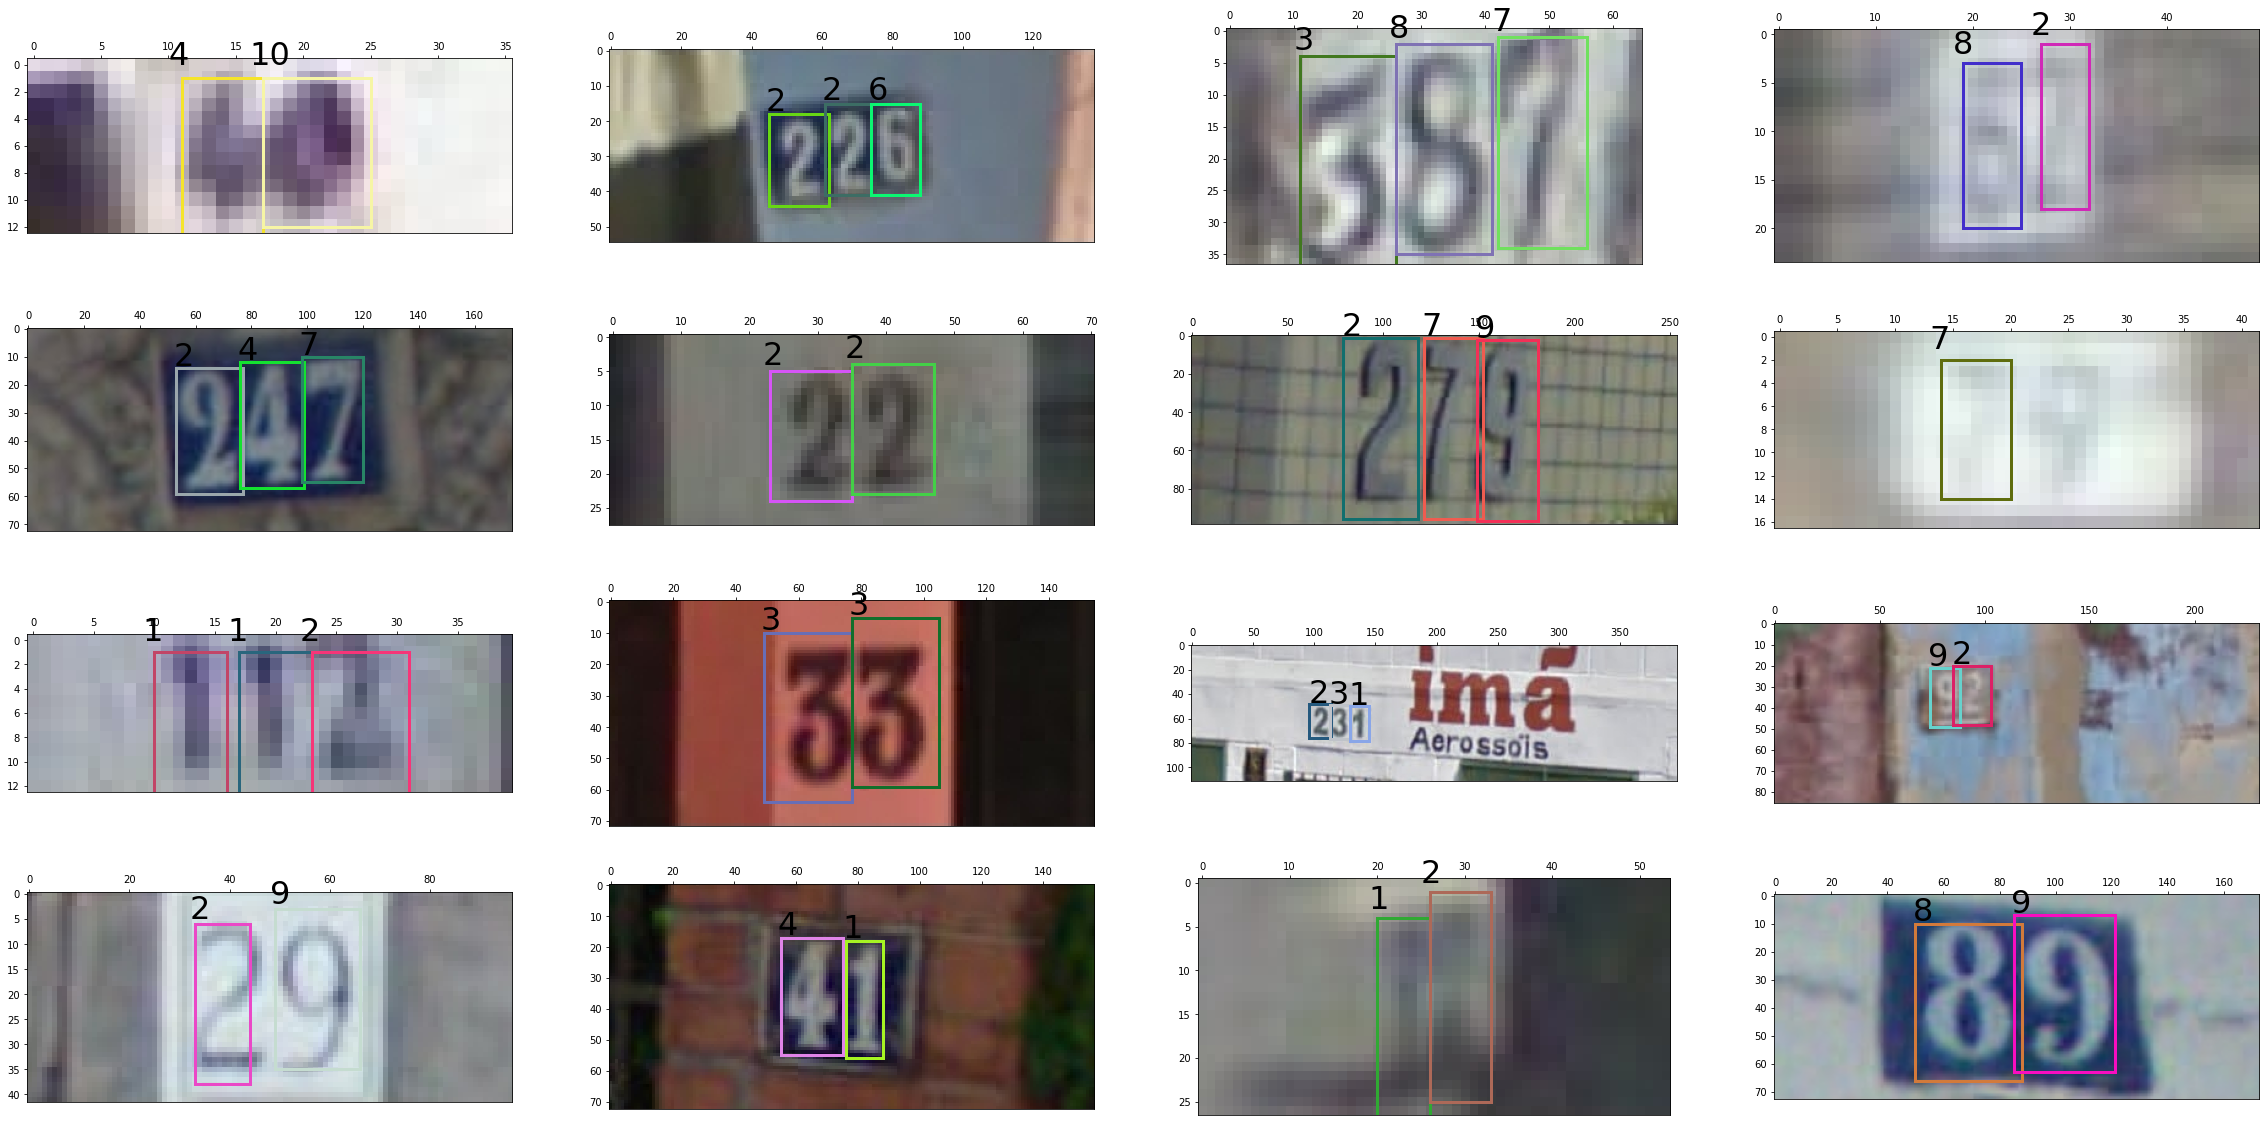

In [14]:
""" Plot 16 random samples """
fig = plt.figure(figsize=(40, 20))
for px in range(16):
    fname = f"{np.random.randint(len(DigitStruct) - 3) + 1}.png"
    im = cv2.imread("train/" + fname)
    im = im[:,:,::-1] # cv2 BGR image to RGB image
    bbox = DigitStruct[fname].astype(np.int32)
    ax = plt.subplot(4, 4, px + 1)
    ax.xaxis.tick_top()
    ax.imshow(im)
    for i in range(bbox.shape[0]):
        x = bbox[i][1]
        y = bbox[i][2]
        w = bbox[i][3]
        h = bbox[i][0]
        if x < 0 or x + w > im.shape[1] or y < 0 or y + h > im.shape[0]:
            print("Warning: invalid boxes {} w/ shape={}".format([x, y, x + w, y + h], im.shape))
        ax.add_patch(patches.Rectangle((x,y),w,h, fill=False, edgecolor=np.random.rand(3), lw=3))
        ax.text(x - 1, y - 1, bbox[i][4], fontsize=32)
plt.show()

[ 57.2130112  128.28498294   3.        ]


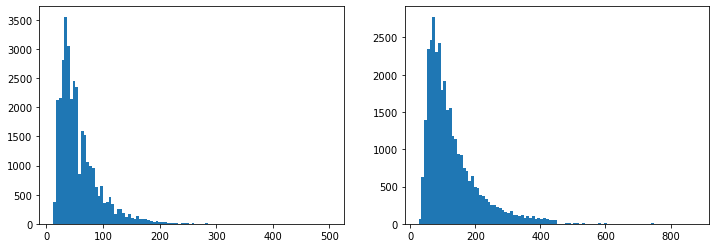

In [14]:
ishapes = np.zeros((33402, 3))
for idx in range(33402):
    fname = "{}.png".format(idx + 1)
    im = cv2.imread("train/" + fname)
    ishapes[idx] = im.shape

print(ishapes.mean(axis=0))
fig = plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(ishapes[:, 0], bins=100)
plt.subplot(122)
plt.hist(ishapes[:, 1], bins=100)
plt.show()

# Keras-Retinanet

## old setup

In [ ]:
!git clone https://github.com/fizyr/keras-retinanet.git
!git clone https://github.com/broadinstitute/keras-resnet.git
!nvidia-smi

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6205, done.
remote: Total 6205 (delta 0), reused 0 (delta 0), pack-reused 6205
Receiving objects: 100% (6205/6205), 13.47 MiB | 8.26 MiB/s, done.
Resolving deltas: 100% (4200/4200), done.
Cloning into 'keras-resnet'...
remote: Enumerating objects: 770, done.
remote: Total 770 (delta 0), reused 0 (delta 0), pack-reused 770
Receiving objects: 100% (770/770), 125.43 KiB | 481.00 KiB/s, done.
Resolving deltas: 100% (444/444), done.
Tue Nov 16 08:05:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MI

In [ ]:
%cd keras-retinanet
!pip install . --user
!python setup.py build_ext --inplace
%cd /content

/content/keras-retinanet
Processing /content/keras-retinanet
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp37-cp37m-linux_x86_64.whl size=168039 sha256=ebae9e1e1756fc035079c63919395768e8e401c0acf9fce890e67a18ae97453c
  Stored in directory: /root/.cache/pip/wheels/32/29/34/9b33c07f08b1be9e77607c1fc6b08c679489aa7ddaed329652
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=4eb18f6b98c008cd17b45c19e290271d50edc3cd5b446586584e5e4272edf426
  Stored in directory: /root/.cache/pip/wheels/bd/ef/06/5d65f696360436c3a423020c4b7fd8c558

In [ ]:
import sys
if "/content/keras-retinanet" not in sys.path:
    sys.path.insert(1, "/content/keras-retinanet") # IMPORTANT
if "/content/keras-resnet" not in sys.path:
    sys.path.insert(1, "/content/keras-resnet") # IMPORTANT
# sys.path

## Generate Keras-Retinanet Anno

In [18]:
DigitStruct = loadmat("digitStruct.mat")
mapper = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0]
img_path_list = []
x1_list = []
y1_list = []
x2_list = []
y2_list = []
category_list = []
for idx in range(33402):
    fname = "{}.png".format(idx + 1)
    im = cv2.imread("train/" + fname)
    bboxes = DigitStruct[fname].astype(np.int32)
    for i in range(bboxes.shape[0]):
        img_path_list.append("train/" + fname)
        x1_list.append(max(bboxes[i][1], 0))
        y1_list.append(max(bboxes[i][2], 0))
        x2_list.append(min(bboxes[i][1] + bboxes[i][3], im.shape[1] - 1))
        y2_list.append(min(bboxes[i][2] + bboxes[i][0], im.shape[0] - 1))
        category_list.append(mapper[int(bboxes[i][4])])
    # assert os.path.exists("train/" + fname)
    # assert fname in DigitStruct.keys()
anno = pd.DataFrame()
anno["img_path"] = img_path_list
anno["x1"] = x1_list
anno["y1"] = y1_list
anno["x2"] = x2_list
anno["y2"] = y2_list
anno["class"] = category_list
tra_anno, val_anno = train_test_split(anno, test_size=0.25, random_state=1116)
tra_anno.to_csv("tra_annotations.csv", index=None, header=None)
val_anno.to_csv("val_annotations.csv", index=None, header=None)

with open("classes.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    for i in range(10):
        writer.writerow([str(i), i])
print(len(tra_anno), len(val_anno))

54942 18315


In [ ]:
df = val_anno.copy()
df.set_index("img_path" , inplace=True)
# df.head()

fname = "8943.png"
fig = plt.figure(figsize=(16, 9))


im = cv2.imread("train/" + fname)
im = im[:,:,::-1] # cv2 BGR image to RGB image
ax = plt.subplot(1, 1, 1)
ax.xaxis.tick_top()
ax.imshow(im)
x = df.loc["train/" + fname]["x1"]
y = df.loc["train/" + fname]["y1"]
w = df.loc["train/" + fname]["x2"] - df.loc["train/" + fname]["x1"]
h = df.loc["train/" + fname]["y2"] - df.loc["train/" + fname]["y1"]
ax.add_patch(patches.Rectangle((x,y),w,h, fill=False, edgecolor=np.random.rand(3), lw=3))
ax.text(x - 1, y - 1, df.loc["train/" + fname]["class"], fontsize=32)
plt.show()

### Debug (Validate anno)

In [ ]:
!mkdir tra_debug val_debug
os.system("python keras-retinanet/keras_retinanet/bin/debug.py --show-annotations " + 
    "--image-min-side 100 --image-max-side 220 --no-gui --output-dir tra_debug csv tra_annotations.csv classes.csv")
os.system("python keras-retinanet/keras_retinanet/bin/debug.py --show-annotations " + 
    "--image-min-side 100 --image-max-side 220 --no-gui --output-dir val_debug csv val_annotations.csv classes.csv")
print("Finish Debug")


Finish Debug


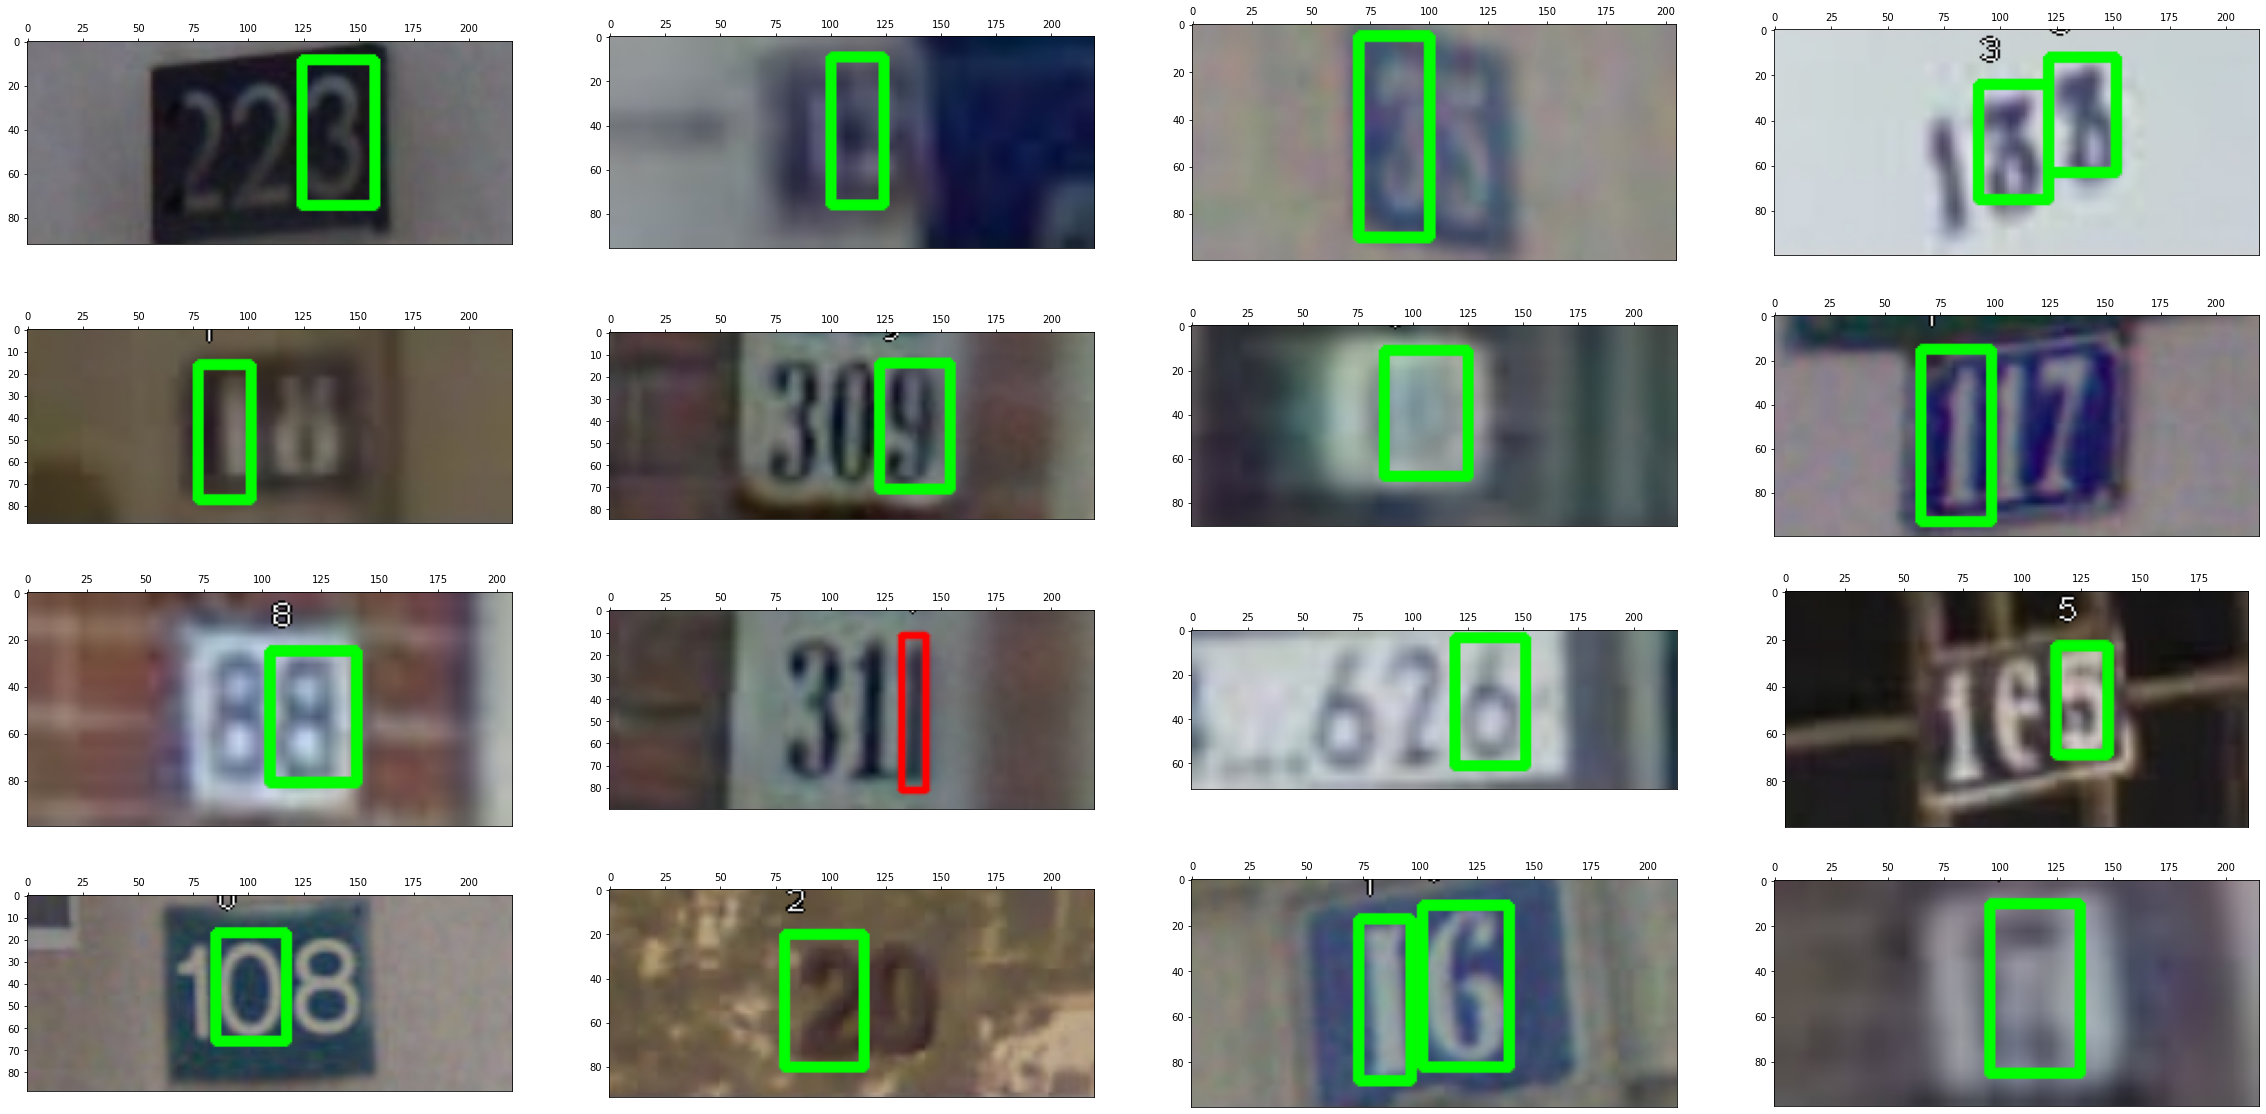

In [ ]:
""" Plot 16 random samples """
ld = os.listdir("val_debug/train")
fig = plt.figure(figsize=(40, 20))
for px in range(16):
    fname = ld[np.random.randint(len(ld))]
    im = cv2.imread("val_debug/train/" + fname)
    im = im[:,:,::-1] # cv2 BGR image to RGB image
    ax = plt.subplot(4, 4, px + 1)
    ax.xaxis.tick_top()
    ax.imshow(im)
plt.show()

In [ ]:
!rm -r tra_debug val_debug # save disk

## Main Process

In [ ]:
"""  Training
retinanet-train --batch-size 32 --epochs 50 --steps 200 \
    --snapshot-path <base-model-path> --image-min-side 100 --image-max-side 220 --compute-val-loss
    csv tra_annotations.csv classes.csv --val-annotations val_annotations.csv > output/train.log
"""

In [ ]:
""" 
# Convert Classifier to Inference Model
retinanet-convert-model <classifier_model_name> <inference_model_name>

# Evaluate Inference Model
retinanet-evaluate --image-min-side 100 --image-max-side 220 \
    csv val_annotations.csv classes.csv <inference_model_name> > output.log
"""

In [ ]:
df = pd.read_csv("val_annotations.csv", header=None, index_col=0)
df#, df.loc["train/" + "16446.png"]

In [22]:
model = models.load_model(BASE_DIR + "m1116/resnet50_ep30_1116.h5", backbone_name="resnet50")
# model.summary()

In [29]:
fname = "28416.png" #f"{np.random.randint(len(DigitStruct) - 3) + 1}.png"
image = cv2.imread("train/" + fname)
# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image, min_side=100, max_side=220)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

processing time:  3.076347589492798


In [ ]:
image.shape, labels, scores

[25.245062  1.912691 35.513664 29.043617] 0.70830625 1
[35.925774   1.7373745 50.580185  28.857004 ] 0.4464147 6


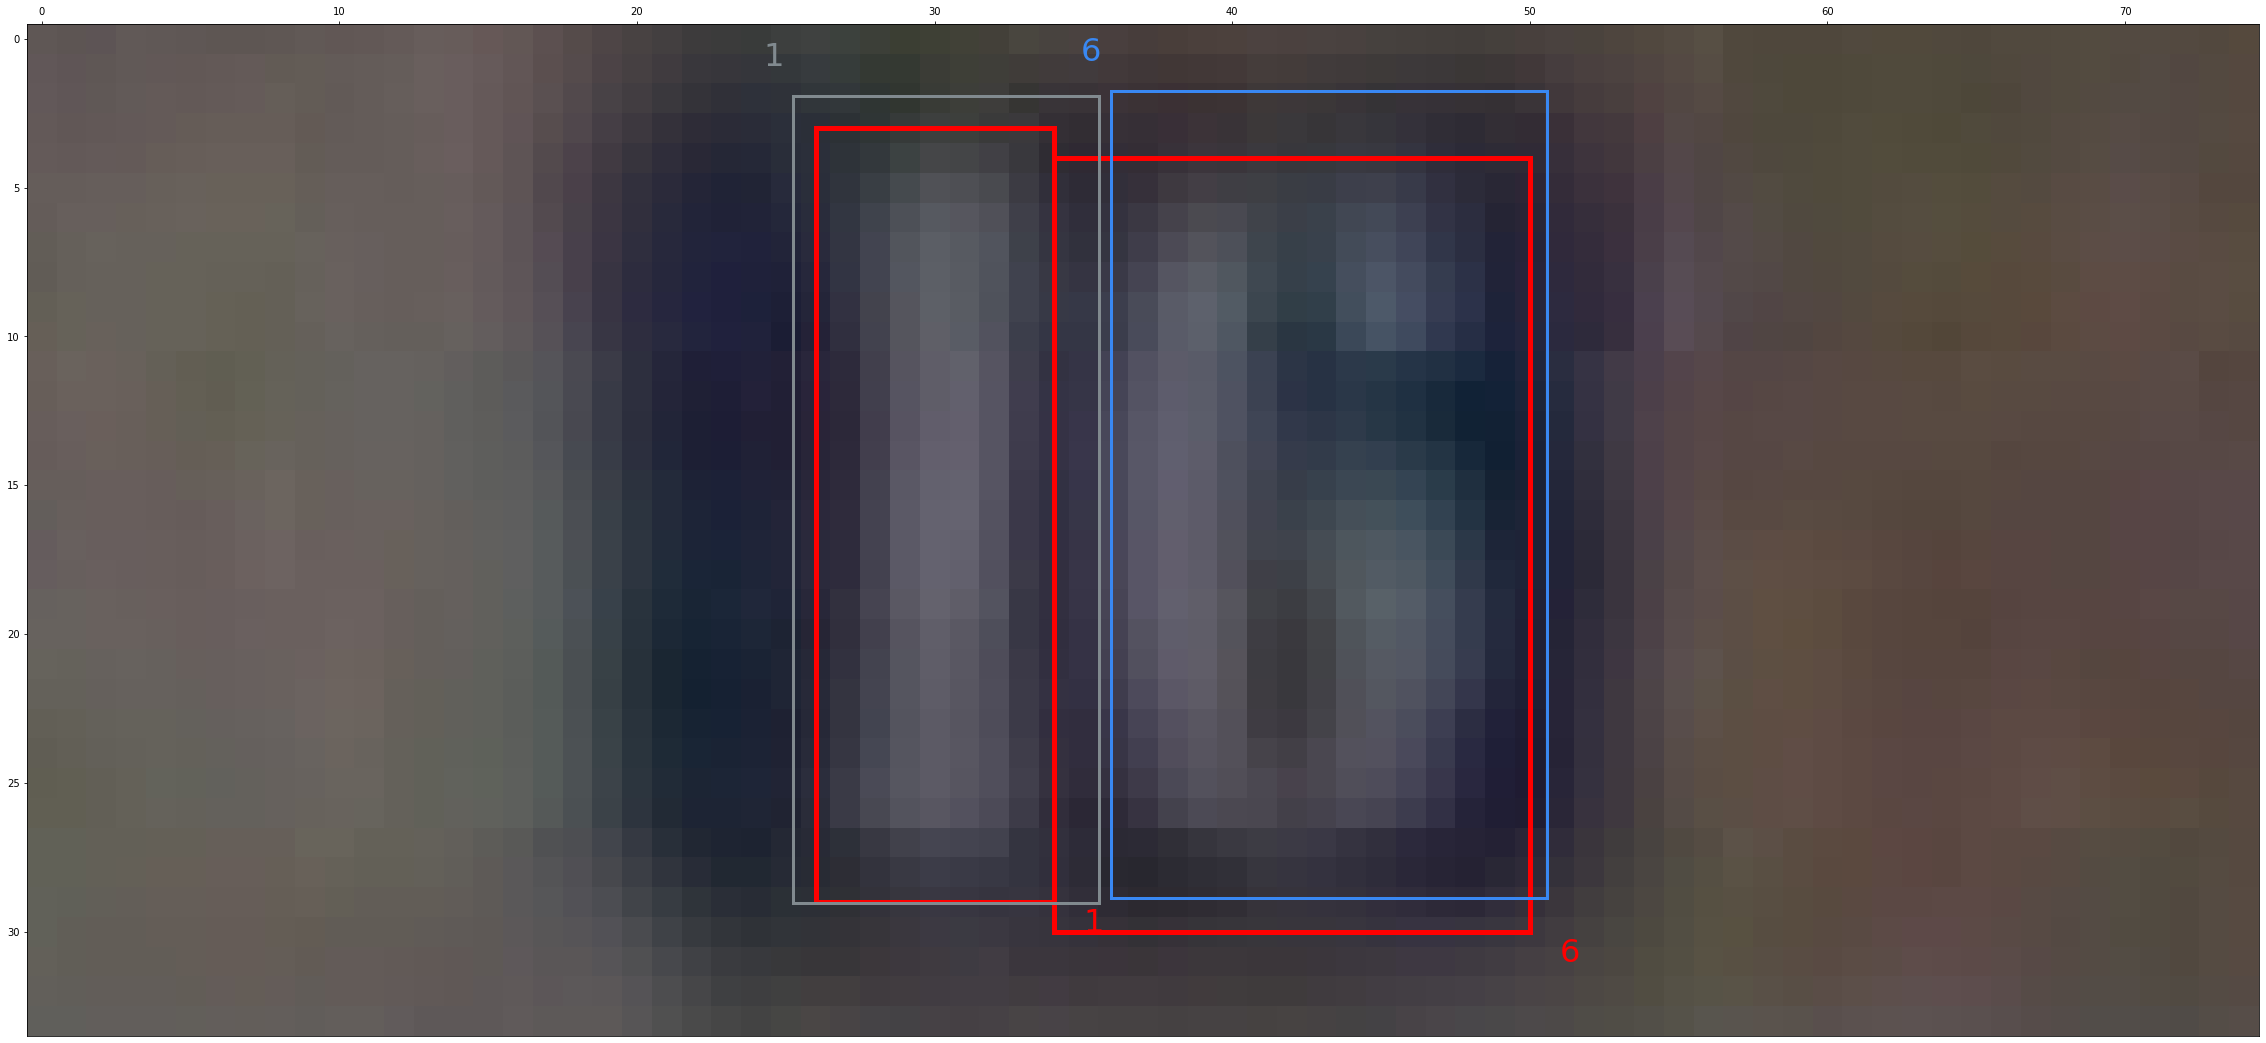

In [42]:
correct_boxes = DigitStruct[fname]
boxes = boxes.squeeze()
scores = scores.squeeze()
labels = labels.squeeze()

plt.figure(figsize=(40, 40))
ax = plt.subplot(1, 1, 1)
ax.xaxis.tick_top()
ax.imshow(draw)
for cb in correct_boxes:
    x = cb[1]; y = cb[2]
    w = cb[3]; h = cb[0]
    ax.add_patch(patches.Rectangle((x, y), w, h, fill=False, edgecolor="red", lw=5))
    ax.text(x + w + 1, y + h + 1, cb[4], fontsize=32, color="red")
for i in range(labels.size):
    # if labels[i] < 0: # -1
    #     break
    if scores[i] < 0.4:
        break
    x = boxes[i][0]; y = boxes[i][1]
    w = boxes[i][2] - boxes[i][0]
    h = boxes[i][3] - boxes[i][1]
    print(boxes[i], scores[i], labels[i])
    color = np.random.rand(3)
    ax.add_patch(patches.Rectangle((x ,y), w, h, fill=False, edgecolor=color, lw=3))
    caption = "{}".format(labels[i])
    ax.text(x - 1, y - 1, caption, fontsize=32, color=color)
plt.show()